<a href="https://colab.research.google.com/github/rmedi21/challenge-telecom-x-2/blob/main/TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [185]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [105]:
# CARGAR BASE DE DATOS
url = "https://raw.githubusercontent.com/rmedi21/challenge-telecom-x-2/refs/heads/main/TelecomX_Data_Depurada.csv"
df = pd.read_csv(url, delimiter=',')

In [165]:
# FUNCIONES
def ancho_bin(df, columna):
    q1, q3 = np.percentile(df[columna], [25, 75])
    iqr = q3 - q1
    ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
    return ancho

def matriz_confusion(y_real, y_prev):
    mc = confusion_matrix(y_real, y_prev)
    fig, ax = plt.subplots(figsize=(4, 3))
    mc_grafico = ConfusionMatrixDisplay(confusion_matrix=mc, display_labels=['Permanece','Cancelado'])
    mc_grafico.plot(cmap='Blues', ax=ax)
    ax.set_xlabel('Valor previsto', fontsize=10, labelpad=10)
    ax.set_ylabel('Valor real', fontsize=10)
    ax.tick_params(axis='both', labelsize=9.5)
    fig.axes[1].tick_params(labelsize=9.5)   # cbar
    ax.set_title("Matriz de Confusion", y=1.02, fontsize=12)

def intervalo_confianza(scores):
    prom = scores.mean()
    desvest = scores.std()
    return f'[{(prom - 2 * desvest):.4f}, {min(prom + 2 * desvest, 1):.4f}]'

#🔧 Preparación

In [107]:
# ELIMINAR COLUMNAS IRRELEVANTES
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df.drop(cols, axis=1, inplace=True)

In [108]:
# CAMBIAR NOMBRES DE VARIABLES
df.rename(columns={'PaperlessBilling': 'Tiene_Factura_Electronica',
                   'Churn': 'Cancelacion'}
          , inplace=True)

In [109]:
# SEPARAR DATASET: Variable objetivo, Variables explicativas
y = df['Cancelacion']
X = df.drop('Cancelacion', axis=1)

### Codificación de Variables

In [110]:
# ONE HOT ENCODING VARIABLES CATEGORICAS
cols = X.columns
cols_categoricas = ['Sexo_Biologico', 'Tiene_Tercera_Edad', 'Tiene_Pareja', 'Tiene_Dependientes', 'Tiene_Telefonia',
                    'Tiene_Multiples_Lineas', 'Servicio_Internet', 'Tipo_Contrato', 'Tiene_Factura_Electronica',
                    'Metodo_Pago', 'Tiene_Internet']

one_hot = make_column_transformer((OneHotEncoder(drop='if_binary'), cols_categoricas),
                                  remainder='passthrough',
                                  sparse_threshold=0,
                                  force_int_remainder_cols=False)

X = one_hot.fit_transform(X)

In [145]:
# NORMALIZACION MIN-MAX VARIABLES NUMERICAS: Adicional para algoritmos que utilicen distancias
norm = MinMaxScaler()

### Correlación y Selección de Variables

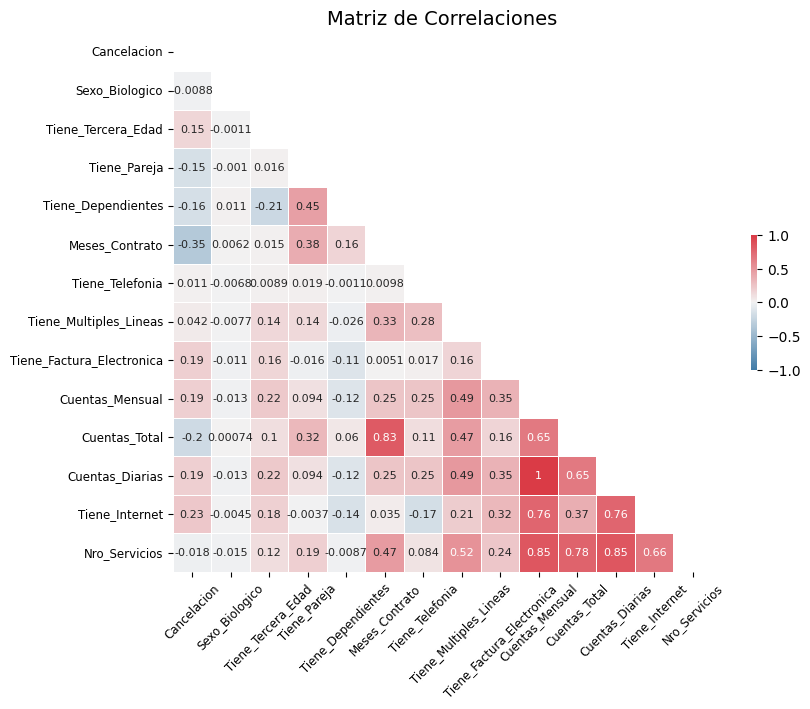

In [115]:
# ANALISIS DE CORRELACION
# -La correlacion entre el Churn y los Meses de contrato es negativa y moderada
# -La correlacion entre el Churn y las Cuentas diarias es positiva y debil
# -La correlacion entre el Churn y el Numero de servicio es es nula
cols = ['Cancelacion', 'Sexo_Biologico', 'Tiene_Tercera_Edad', 'Tiene_Pareja',
       'Tiene_Dependientes', 'Meses_Contrato', 'Tiene_Telefonia',
       'Tiene_Multiples_Lineas', 'Tiene_Factura_Electronica', 'Cuentas_Mensual',
       'Cuentas_Total', 'Cuentas_Diarias', 'Tiene_Internet', 'Nro_Servicios']
corr = df[cols].corr()

mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

fig, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(
        corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0, square=True,
        linewidths=.5, annot=True,
        cbar_kws={"shrink": .25}, annot_kws={'size': 8}
    )

plt.title("Matriz de Correlaciones",  y=1.0, fontsize=14)
plt.xticks(fontsize=8.5, rotation=45)
plt.yticks(fontsize=8.5)

# plt.savefig("matriz_correlaciones.png", bbox_inches='tight', dpi=300)
# plt.close()
plt.show()

In [116]:
# MATRIZ DE CORRELACION COMPLETA (INC. LABEL ENCODER EN PANDAS)

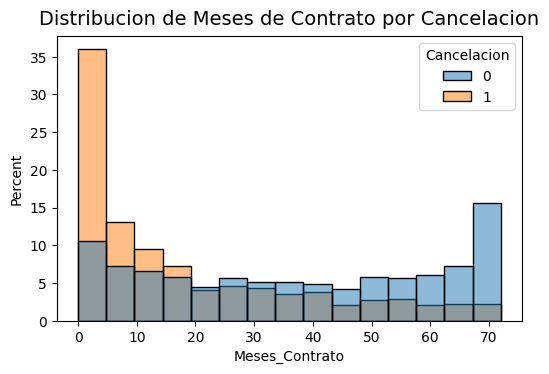

In [117]:
# ANALISIS DIRIGIDO
# Distribucion de Tiempo de Contrato por Cancelacion:
# -Los clientes cancelados tienen menos meses de contrato
# -A medida que aumentan el tiempo de contrato menos clientes cancelan
anchobin = ancho_bin(df, 'Meses_Contrato')

fig, ax = plt.subplots(figsize=(6, 3.7))

sns.histplot(
    data=df, x="Meses_Contrato", hue="Cancelacion",
    stat="percent", binwidth=anchobin, common_norm=False,
    ax=ax
)

plt.title("Distribucion de Meses de Contrato por Cancelacion", y=1.01, fontsize=14)

plt.show()
# plt.savefig("distribucion_meses_contrato_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

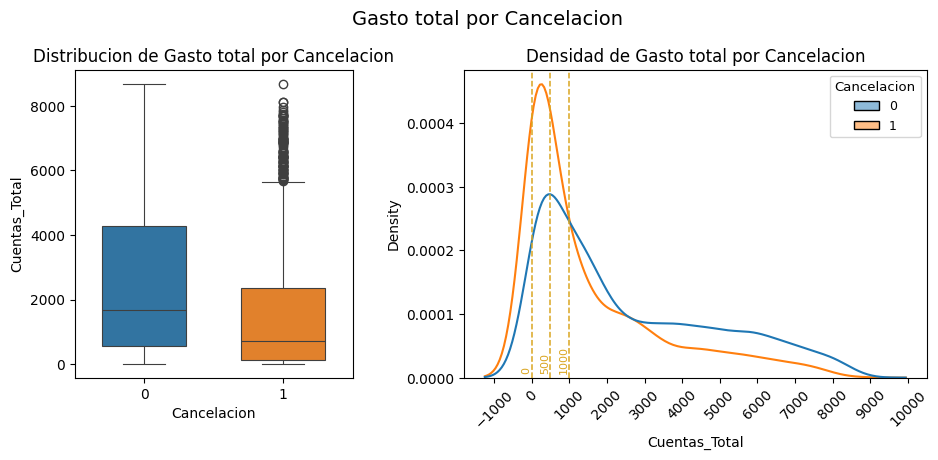

In [118]:
# Boxplot y Densidad del Gasto total por Cancelacion:
# -Los clientes cancelados y no cancelados tienen asimetria positiva:
#   -Alta concentracion de clientes con gastos bajos
#   -A medida que aumenta el gasto disminuye la cantidad de clientes
# -Sin embargo, los clientes cancelados tienen mayor concentracion en gastos bajos:
#   -El 50% de cancelados tiene un gasto < 713, los no cancelados un gasto < 1683 (mas del doble)
#   -El 75% de cancelados tiene un gasto < 2345, los no cancelados un gasto < 4264 (80% mas)
fig, axs = plt.subplots(1, 2, figsize=(11, 4), width_ratios=[1.2, 2])

# Boxplot
axs[0] = sns.boxplot(
            data=df, x='Cancelacion', y='Cuentas_Total', hue='Cancelacion',
            width=.6, linewidth=.8, legend=False,
            ax=axs[0]
         )
axs[0].set_title('Distribucion de Gasto total por Cancelacion', y=1, fontsize=12)

# Kdeplot
axs[1] = sns.kdeplot(
            data=df, x="Cuentas_Total", hue="Cancelacion",
            common_norm=False, legend=True,
            ax=axs[1]
         )
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1000))
axs[1].tick_params(axis='x', labelsize=10, labelrotation=45)
axs[1].axvline(x=0, linewidth=1.1, color='goldenrod', linestyle='--')
axs[1].axvline(x=500, linewidth=1.1, color='goldenrod', linestyle='--')
axs[1].axvline(x=1000, linewidth=1.1, color='goldenrod', linestyle='--')
axs[1].text(-20, 9E-6, '0', fontsize=8, color='goldenrod', ha='right', rotation=90)
axs[1].text(480, 9E-6, '500', fontsize=8, color='goldenrod', ha='right', rotation=90)
axs[1].text(980, 9E-6, '1000', fontsize=8, color='goldenrod', ha='right', rotation=90)
axs[1].set_title("Densidad de Gasto total por Cancelacion", y=1, fontsize=12)
# kdeplot - leyenda
handles = ax.legend_.legend_handles
texts = axs[1].legend_.texts
[handle.set_label(text.get_text()) for handle, text in zip(handles, texts)]
axs[1].legend(handles=handles, title='Cancelacion', prop={'size': 9}, loc='upper right', title_fontsize=9.5)

fig.suptitle("Gasto total por Cancelacion",  y=1.03, fontsize=14)
fig.subplots_adjust(wspace=0.3)

plt.show()
# plt.savefig("boxplot_densidad_gasto_total_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

In [16]:
# SELECCION DE VARIABLES
# Se mantienen las variables relevantes para el modelo predictivo
# TODO: Eliminar variables

#📊 Modelamiento Predictivo

In [17]:
# SEPARACION DE DATOS
# Se hace la division estratificada para mantener la proporcion de variable de respuesta
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=5)

In [18]:
y_train.value_counts()

,count
Cancelacion,
0,3614
1,1300


In [19]:
y_test.value_counts()

,count
Cancelacion,
0,1550
1,557


In [20]:
# MODELO BASE: Modelo de referencia basico para comparar modelos mas avanzados
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier()

In [177]:
# EVALUACION MODELO
# El score representa la mayor frecuencia de la variable respuesta (No = 0.74)
dummy.score(X_test, y_test)

0.7356430944470812

### Modelo KNN

In [146]:
# ENTRENAMIENTO MODELO
# Se normalizan las variables explicativas numericas pues el algoritmo KNN utiliza distancias
# -Una escala comun hace que las variables no tengan sesgos de escala y contribuyan equitativamente al modelo
X_train_norm = norm.fit_transform(X_train)

modelo_knn = KNeighborsClassifier()
modelo_knn.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [147]:
# EVALUACION MODELO (preliminar)
# Tiene igual precision que el modelo base (0.76). No mejora la capacidad predictiva
X_test_norm = norm.transform(X_test)
modelo_knn.score(X_test_norm, y_test)

print('****************** KNN ******************')
print(f'Exactitud en set de entrenamiento: {modelo_knn.score(X_train, y_train):.4f}')
print(f'Exactitud en set de pruebas: {modelo_knn.score(X_test, y_test):.4f}')

****************** KNN ******************
Exactitud en set de entrenamiento: 0.7354
Exactitud en set de pruebas: 0.7356


### Modelo Random Forest

In [119]:
# ENTRENAMIENTO MODELO
modelo_rf = RandomForestClassifier(max_depth=10, random_state=5)
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=5)

In [140]:
# EVALUACION MODELO (preliminar)
# Tiene mayor precision que el KNN (0.79)
# !Existe diferencia marcada en los sets
print('************* Random Forest *************')
print(f'Exactitud en set de entrenamiento: {modelo_rf.score(X_train, y_train):.4f}')
print(f'Exactitud en set de pruebas: {modelo_rf.score(X_test, y_test):.4f}')

************* Random Forest *************
Exactitud en set de entrenamiento: 0.8716
Exactitud en set de pruebas: 0.7902


# Evaluacion de Modelos

### Modelo KNN

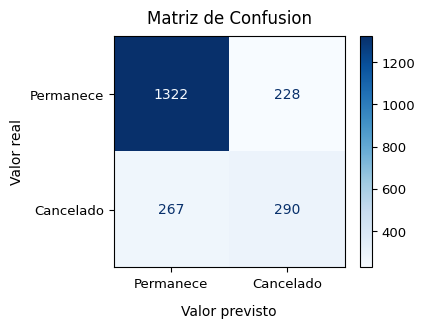

In [149]:
# MATRIZ DE CONFUSION
# Se predijo correctamente 285 clientes cancelados.
# se clasifico incorrectamente 272 clientes como permanecen pero son cancelados
# se clasifico incorrectamente 170 clientes como cancelados pero son permanecen
X_test_norm = norm.fit_transform(X_test)
y_prev_knn = modelo_knn.predict(X_test_norm)

matriz_confusion(y_test, y_prev_knn)
plt.show()
# plt.savefig("matriz_confusion_modelo_knn.png", bbox_inches='tight', dpi=300)
# plt.close()

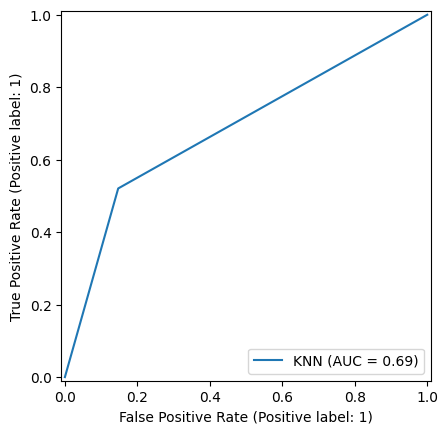

In [164]:
# CURVA ROC
# El AUC es alto (0.69) por lo tanto el modelo logra discriminar
RocCurveDisplay.from_predictions(y_test, y_prev_knn, name="KNN");

In [150]:
# METRICAS
# El objetivo es reducir la cancelacion, entonces se debe disminuir el error tipo 2 (falsos negativos)
# Por lo tanto, se debe optimizar la Sensibilidad
# La Sensibilidad es moderada (0.5206)
print('******* Modelo KNN *******')
print(f'Precision:    {precision_score(y_test, y_prev_knn):.4f}')
print(f'Sensibilidad: {recall_score(y_test, y_prev_knn):.4f}')
print(f'Exactitud:    {accuracy_score(y_test, y_prev_knn):.4f}')
print(f'F1-score:     {f1_score(y_test, y_prev_knn):.4f}')

******* Modelo KNN *******
Precision:    0.5598
Sensibilidad: 0.5206
Exactitud:    0.7651
F1-score:     0.5395


### Modelo Random Forest

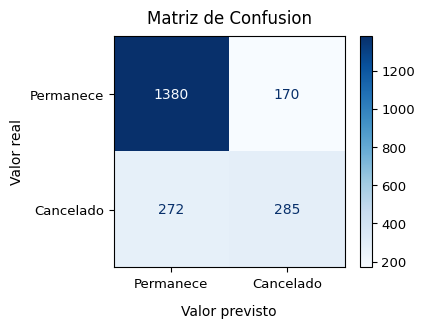

In [130]:
# MATRIZ DE CONFUSION
# Se predijo correctamente 285 clientes cancelados.
# se clasifico incorrectamente 272 clientes como permanecen pero son cancelados
# se clasifico incorrectamente 170 clientes como cancelados pero son permanecen
y_prev_rf = modelo_rf.predict(X_test)

matriz_confusion(y_test, y_prev_rf)
plt.show()
# plt.savefig("matriz_confusion_modelo_rf.png", bbox_inches='tight', dpi=300)
# plt.close()

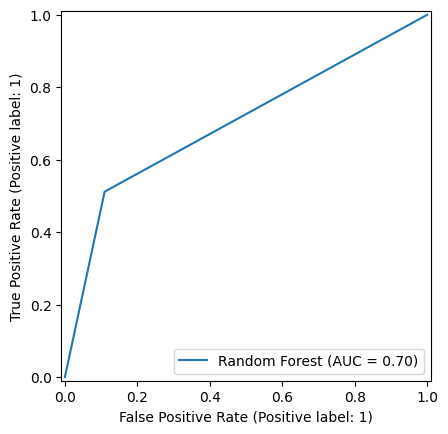

In [157]:
# CURVA ROC
# El AUC es alto (0.7) por lo tanto el modelo logra discriminar
RocCurveDisplay.from_predictions(y_test, y_prev_rf, name="Random Forest");

In [138]:
# METRICAS
# El objetivo es reducir la cancelacion, entonces se debe disminuir el error tipo 2 (falsos negativos)
# Por lo tanto, se debe optimizar la Sensibilidad
# La Sensibilidad es moderada (0.5117)
print('***** Modelo Random Forest *****')
print(f'Precision:    {precision_score(y_test, y_prev_rf):.4f}')
print(f'Sensibilidad: {recall_score(y_test, y_prev_rf):.4f}')
print(f'Exactitud:    {accuracy_score(y_test, y_prev_rf):.4f}')
print(f'F1-score:     {f1_score(y_test, y_prev_rf):.4f}')

***** Modelo Random Forest *****
Precision:    0.6264
Sensibilidad: 0.5117
Exactitud:    0.7902
F1-score:     0.5632


### VALIDACION

In [174]:
# VALIDACION CRUZADA CON BALANCEO DE DATOS Y PIPELINE
# Se utiliza pipeline para desbalancear los datos en la validacion
# Se valida el mejor modelo: Random Forest
# Se evaluara con la metrica de sensibilidad, para reducir el error tipo 2
modelo = RandomForestClassifier(max_depth=10)

In [180]:
# OVERSAMPING
# La sensibilidad es mayor a la del modelo (0.62 > 0.51)
pipeline = imbpipeline([('oversample', SMOTE()), ('rf', modelo)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_results = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')

intervalo_confianza(cv_results)

'[0.5620, 0.6887]'

In [181]:
# UNDERSAMPLING
# La sensibilidad mejora con respecto al oversampling (0.70 > 0.62)
pipeline = imbpipeline([('undersample', NearMiss(version=3)), ('rf', modelo)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_results = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')

intervalo_confianza(cv_results)

'[0.6401, 0.7614]'

In [182]:
# BALANCEO MIXTO
# La sensibilidad mejora con respecto al undersampling (0.74 > 0.70)
pipeline = imbpipeline([('smoteenn', SMOTEENN()), ('rf', modelo)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_results = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')

intervalo_confianza(cv_results)

'[0.6935, 0.7896]'

### PROBAR MODELO

In [183]:
# ENTRENAR MODELO CON DATA BALANCEADA
# Se utiliza el metodo SMOTEENN, pues obtuvo mejor sensibilidad en la validacion
balanceo = SMOTEENN()
x_balanced, y_balanced = balanceo.fit_resample(X_train, y_train)

modelo = RandomForestClassifier(max_depth=10)
modelo.fit(x_balanced, y_balanced)

RandomForestClassifier(max_depth=10)

In [184]:
# PREDICCION
y_prev = modelo.predict(X_test)

In [186]:
# METRICAS
# La sensibilidad es 0.75, la cual es muy buena.
# El costo a asumir es el aumento en la precision (falsos positivos); paso de 0.63 a 0.54
print(classification_report(y_test, y_prev))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1550
           1       0.54      0.75      0.63       557

    accuracy                           0.77      2107
   macro avg       0.72      0.76      0.73      2107
weighted avg       0.80      0.77      0.78      2107



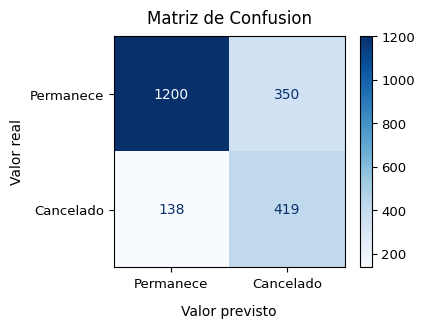

In [187]:
# MATRIZ CONFUSION
matriz_confusion(y_test, y_prev)
plt.show()

#📄Informe final

## Introducción
La empresa enfrenta una alta tasa de cancelaciones y necesita comprender los factores que llevan a la pérdida de clientes.

El objetivo de este proyecto es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

Además de ello, se busca responder las siguientes preguntas:<br/>
¿Quienes son los clientes con mayor riesgo de cancelación?<br/>
¿Qué variables influyen más en este comportamiento?<br/>
¿Qué tipo de perfil necesita la empresa para mantenerse más cerca?


## Limpieza y Tratamiento de Datos


En lo que respecta a la limpieza de los datos, se realizaron las siguientes acciones:
* Eliminar columna código de cliente (*CustomerID*)
* Eliminar registros sin target (*Churn* con valor vacío [''])
* Identificar y eliminar registros duplicadas
* Corregir monto total:
 + Ajustar tipo de dato a *float*
 + Imputar monto total con valores vacíos
* Homologar valores:
 + No internet service -> No
 + No phone service -> No
* Feature Engineering:
 + Normalizar las variables numéricas con el método *Min Max Scaling*
 + Codificar las variables categoricas con *OneHot Encoding*
* Crear columnas:
 + Cuentas_Diarias = Cuentas_Mensual / 30
 + Tiene_Internet = Servicio_Internet in ('DSL', 'Fiber optic') -> 1, Servicio_Internet = 'No' -> 0
 + Nro_Servicios = Numero de servicios contratados

## Análisis Exploratorio de Datos
Una vez la base de datos se encuentra limpia y formateada, procedemos con el análisis descriptivo.
<br/>
* **Variables categóricas**<br/>
Se observa que el Churn por sexo biológico muestra igual proporción de clientes en ambos sexos:
<img alt='Distibucion de churn por sexo' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_sexo.png' width="450" height="315" />
<br/><br/>
Si analizamos por Método de pago, se observa que el cheque electrónico tiene mayor fuga que los otros métodos de pago, que presentan distribución en similar proporción:
<img alt='Distibucion de churn por metodo pago' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_metodo_pago.png' width="800" height="315" />
<br/><br/>
En el análisis por Tipo de contrato el contrato mensual tiene mayor fuga que los otros tipos:
<img alt='Distibucion de churn por tipo contrato' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_tipo_contrato.png' width="620" height="315" />
<br/><br/>
* **Variables numéricas**<br/>
Analizamos la distribucion del Total gastado por Churn utilizando un gráfico de densidad. Se observa que ambas distribuciones son semejantes:<br/>
    -Alta concentracion de clientes con gastos bajos<br/>
    -A medida que aumenta el gasto disminuye la cantidad de clientes
<img alt='Distibucion de total gastado por churn' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/densidad_cuenta_total_churn.png' width="630" height="450" />
<br/><br/>
* **Correlación de variables**<br/>
Se analizó la correlación de las variables numéricas con la variable objetivo obteniendo lo siguiente:<br/>
    -La correlación entre el Churn y los Meses de contrato es negativa y moderada<br/>
    -La correlación entre el Churn y las Cuentas diarias es positiva y débil<br/>
    -La correlación entre el Churn y el Número de servicio es es nula<br/>
<img alt='Matriz de correlaciones' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/matriz_correlaciones.png' width="450" height="420" />

## Entrenamiento
Para entrenar el modelo se escogieron los algoritmos KNN y Random Forest.

## Validación
Para la etapa de validación se realizó:
+ Matriz Confusión
+ Curva ROC
+ Métricas: nos centramos en la Sensibilidad, pues se quiere reducir el error tipo 2.
+ Validación cruzada y balanceo de datos: se utiliza un balanceo de datos, junto con una técnica de validación cruzada estratifica para evaluar la sensibilidad. Se utiliza para automatizar el proceso un pipeline.

## Conclusiones e Insights
- Se puede observar un comportamiento diferenciado para el Churn por la variable Meses de contrato y Cuentas diarias, según los gráficos analizados.
- Lo anterior se corrobora con la matriz de correlaciones, aunque se muestra una correlación moderada y débil respectivamente.
- Entonces una forma de reducir el Churn es hacer que el cliente se mantenga varios meses con el servicio y que su facturación diaria sea mínima.
<br/><br/>

## Recomendaciones
- Se recomienda balancear los datos debido a que los clientes que permanecen son la clase dominante (la relación es de 3 a 1 con los fugados).
- Se recomienda trabajar el modelo predictivo con las variables analizadas (Sexo_Biologico, Metodo_Pago, Meses_Contrato, Cuentas_Diarias, Numero_Servicios).